# Clase 19: Reinforcement Learning

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

## Objetivos

- Introducir al estudiante a la disciplina de Reinforcement Learning
- Conocer sobre MDP y sus principales componentes
- Aprender a resolver problemas de RL mediante Q-learning
- Aprender a implementar algoritmos basados en DRL usando Stable-Baselines3

## Sistemas Autónomos

Los **Sistemas Autónomos** son modelos o sistemas diseñados para operar sin la necesidad de supervisión humana. Al igual que otros sistemas, reciben una entrada $X$ y generan una salida $f(X)$. Sin embargo, su característica distintiva es la capacidad de **operar de manera independiente**. Esta autonomía se basa en la capacidad del sistema para ejecutar acciones en momentos específicos, conocidos como **triggers**. Por ejemplo, un sistema autónomo podría activarse automáticamente una vez al día a las 12:00 PM, o en respuesta a acciones específicas del usuario, como enviar un mensaje a un chatbot.

El siguiente diagrama ilustra la idea del párrafo anterior:

<div style="text-align: center;">
    <img src="../../recursos/2024-01/rl/autonomous.png" style="width: 35%;">
</div>

Veamos un ejemplo de un sistema autónomo simple:

In [24]:
import numpy as np

# definición de modelo
f = lambda x: 1 if x >= 0 else -1 # modelo

# modelo en "producción"
outputs = []
for _ in range(1000): # período en el que se ejecuta el sistema
  x = np.random.randn() # entrada del sistema
  f_x = f(x) # salida del sistema
  outputs.append(f_x) # guardamos salida

outputs[:10]

[-1, -1, -1, -1, -1, -1, -1, 1, -1, 1]

A lo largo de esta y la próxima clase trabajaremos con dos grandes paradigmas para generar sistemas autónomos: **Reinforcement Learning** y **LLM**.

## Reinforcement Learning

<div style="text-align: center;">
    <img src="https://datasciencedojo.com/wp-content/uploads/ml-ds-algos.jpg" style="width: 35%;">
</div>

### ¿Qué es?

**Reinforcement Learning** (también conocido como aprendizaje reforzado) es un marco para resolver **tareas dinámicas** de control de forma **autónoma** y a través de **agentes**. Estos agentes son entrenados a partir de **interacciones prueba-error con un ambiente**, *reforzando* las interacciones "buenas" y *castigando* las interacciones "malas".

### ¿Cómo se distingue de lo que ya hemos aprendido?

El aprendizaje reforzado posee varios elementos distintivos que lo diferencian del Apredizaje Supervisado Tradicional, en particular:

- **Resuelve problemas de control dinámico**: Esto quiere decir que no buscaremos la mejor acción, sino la **mejor secuencia de acciones** que nos llevan a alcanzar nuestro objetivo de forma autónoma. Este aspecto del problema no es trivial, pues tiene por supuesto que nuestro problema contiene **dependencia entre los estados temporales** (por ejemplo, para jugar ajedrez no es lo mismo mover el caballo y la reina, que la reina y el caballo). 

> **Pregunta:** ¿Qué pasa si mi problema no posee esta dependencia temporal?

- **No necesita de datos etiquetados, pero necesita de un ambiente**: A diferencia del aprendizaje supervisado donde queremos aproximar lo mejor posible a una variable objetivo, en apredizaje reforzado se busca generar una propia distribución que resuelva el problema a través de interacciones prueba y error. ¿Qué significa esto? Pensemos por un momento que queremos entrenar un modelo que juegue Mario Bros:
    - Si quisiéramos modelar esto con aprendizaje supervisado, necesitaríamos de un dataset con las imágenes del juego y la *mejor jugada* dada estas imágenes (típicamente obtenida de un experto). Por lo tanto, **nuestro modelo podría ser tan bueno jugando Mario Bros como lo sea el experto.**
    - Si quisiéramos mdoelar esto con aprendizaje reforzado, necesitaríamos de un ambiente con las *reglas* de Mario Bros (¿qué pasa si me muevo hacia la derecha o a la izquierda?). Luego, nuestro modelo aprendería a interacciones prueba-error cual es el mejor set de acciones para resolver nuestro problema. Por lo tanto, **nuestro modelo podría ser el <u>mejor</u> jugador de Mario Bros**.

> **Pregunta:** ¿Qué implicancias tiene esto para la humanidad?

### ¿Cómo funciona?

Para poder entrenar nuestro agente debemos contar con el siguiente esquema de entrenamiento:
1. El **agente observa** la información disponible entregada por el ambiente
2. Considerando la observación obtenida, el **agente ejecuta una acción**
3. La acción "impacta" al ambiente, devolviendo una **recompensa** (feedback de qué tan buena fue la acción ejecutada) y una **nueva observación**
4. Volver al paso 1

De esta forma, la idea es repetir muchas (**muchas!**) veces estos pasos para así maximizar las recompensas obtenidas. Como salida, obtendremos una política $\pi$ con la distribución de probabilidades de qué accion ejecutar en un momento determinado.

### Ejemplos

Entre algunos ejemplos notables de aplicaciones de RL podemos encontrar:
- [Robótica](https://www.youtube.com/watch?v=k7K7JG_RQhQ)
- [Vehículos Autónomos ](https://www.youtube.com/watch?v=fKBes088KV4)
- [AlphaGo](https://deepmind.google/technologies/alphago/)

> **Pregunta:** ¿Qué otros ejemplos de se les ocurre que puedan ser modelados con RL?

## Problema de hoy

Para ejemplificar los conceptos y consolidar lo aprendido, el dia de hoy trabajaremos en resolver el videojuego **Frozen Lake**. Este videojuego ilustra la tarea de un elfo navideño, el cual debe atravesar por un lago congelado evitando caer al agua y así recuperar el regalo de navidad. Pueden encontrar la definición formal del problema en este [link](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

Conociendo el contexto, **¿como podemos usar RL para resolver este problema?**

<div style="text-align: center;">
    <img src="https://www.gymlibrary.dev/_images/frozen_lake.gif" style="width: 20%;">
</div>

## Markov Decision Process (MDP)

El primer paso para usar RL es formular nuestro problema como un **Proceso de Decisión de Markov** (MDP). Un MDP es un proceso de control estocástico en tiempo discreto, el cual proporciona un marco matemático para **modelar la toma de decisiones** en problemas donde los resultados son controlados por un tomador de decisiones. Los procesos de decisión de Markov son una extensión de las cadenas de Markov y son utilizados en muchas disciplinas, incluyendo la robótica, el control automático, la economía y la manufactura.

Un Proceso de Decisión de Markov se constituye de los siguientes elementos:

- **Estados**: También se le llama *observaciones*, es la información que obtiene el agente del ambiente.
- **Acciones**: Set de acciones posibles a realizar por el agente.
- **Recompensas**: Feedback otorgado al agente por ejecutar una acción $a$ en un estado $s$.

donde la colección $(S_0, A_0, R_1, S_1)$ se le conoce como una **experiencia**.

> **Pregunta:** ¿Quién define los Estados, Acciones y Recompensas? ¿Existe una única definición de estos elementos?

<div style="text-align: center;">
    <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit1/sars.jpg" style="width: 25%;">
</div>

De esta manera, en el tiempo $t$ el agente recibe el estado $S_t$, a lo que responde ejecutando una acción $A_t$. Esta acción altera el ambiente, otorgando una recompensa $R_t$ y retornando un nuevo estado $S_{t+1}$. Dado que $S_{t+1}$ depende únicamente del conjunto $(S_t, A_t)$ se concluye que la transición de entre estados cumple la <u>**Propiedad de Markov**</u>: Agentes solo deben tener en cuenta el **estado actual** $S_t$ para decidir qué acción tomar y **<u>NO</u> la historia de todos los estados y acciones anteriores**.

El siguiente diagrama ilustra la representación típica de un MDP:

<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ywOrdJAHgSL5RP-AuxsfJQ.png" style="width: 50%;">
</div>

Detallemos un poco mejor cada uno de los componentes antes mencionados.

### Estados

Las **Observaciones o Estados** son la información que nuestro agente obtiene del entorno. En el caso de un videojuego, esto podría ser una captura de pantalla. Para un agente de trading, podría ser el valor de una acción específica, entre otros ejemplos.

Sin embargo, hay una diferencia que hacer entre observación y estado:

- **Estado**: Entrega una **descripción completa** del estado del ambiente. Es un entorno completamente observado. 
- **Observación**: Es una **descripción parcial** del estado del ambiente.

<div style="text-align: center;">
    <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit1/obs_space_recap.jpg" style="width: 35%;">
</div>

Un aspecto importante a considerar es que **no existe una única representación de las observaciones.** Por ejemplo, el MDP puede recoger observaciones de solo algunas piezas del ajedrez y aún así llegar a un buen resultado (aunque esto probablemente sea una mala idea). Es responsabilidad del programador preocuparse para que las observaciones recibidas por el agente sean de utilidad para obtener buenos resultados, teniendo especial cuidado en respetar la Propiedad de Markov.

Volviendo al problema de **Frozen Lake**, los estados son definidos a partir de la posición en la cuadrídula del agente (elfo). Como el mapa tiene un tamaño de 4x4, existen 16 estados posibles, los cuales pueden ser enumerados de la siguiente manera:

<div style="text-align: center;">
    <img src="../../recursos/2024-01/rl/states.png" style="width: 20%;">
</div>

Donde se observa que el agente comenzará siempre en el estado 0 y su meta es llegar al estado 15.

### Acciones

Las acciones hacen referencia a todo el set posible de acciones a ejecutar por el agente. 

El espacio de acciones puede ser de dos tipos:

- **Discreto**: El número de acciones posibles es **finito**
- **Continuo**: El número de acciones posibles es **infinito**

<div style="text-align: center;">
    <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit1/action_space.jpg" style="width: 35%;">
</div>

**Ojo! Tener presente el tipo de acciones (discretas o continuas) de nuestro ambiente es un aspecto <u>crucial</u> para elegir el algoritmo de RL.**

Retornando a nuestro problema, **Frozen Lake** puede ser caracterizado como un ambiente de **acciones discretas** con 4 acciones posibles:

- **0**: Izquierda ⬅️
- **1**: Abajo ⬇️
- **2**: Derecha ➡️
- **3**: Arriba ⬆️

donde cada elemento representa la dirección de movimiento del elfo navideño.

### Recompensas

Las recompensas son fundamentas en RL pues son el **único feedback del agente**. A través del agente, el **agente aprende si la acción ejecutada fue buena o no**. 

En el ejemplo del ajedrez, el agente puede obtener una recompensa positiva si captura una pieza del oponente, y una recompensa negativa si el oponente captura una pieza del agente.

La recompensa acumulada en cada timestep $t$ puede ser escrita como:

$$R(\tau) = r_{t+1} + r_{t+2} + r_{t+3} + r_{t+4} + ...$$
$$R(\tau) = \sum_{k=0}^{\infty} r_{t+k+1}$$

Dado que las recompensas futuras son más lejanas de $t$ y por lo tanto menos deseables, un procedimiento común es descontar las recompensas futuras por un factor $\gamma$:

$$R(\tau) = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \gamma^3 r_{t+4} + ...$$
$$R(\tau) = \sum_{k=0}^{\infty} \gamma^k r_{t+k+1}$$

donde $\gamma$ es un factor definido por el programador y usualmente varia entre los valores 0.95 y 0.99.

Al igual que los estados, el **esquema de recompensas no es único y puede ser configurable por el usuario**. Es responsabilidad del usuario definir un buen esquema de recompensas acorde al problema a resolver para lograr una solución efectiva.

Para el problema de **Frozen Lake**, las recompensas son definidas en función de la posición del elfo:

- **Regalo**: +1
- **Agua**: +0
- **Hielo**: +0

> **Pregunta**: ¿Qué problemas podría tener este esquema de recompensas?

## Formalización del problema

El objetivo de Aprendizaje Reforzado es **encontrar una política $\pi$ que maximice la recompensa del agente** a lo largo del experimento. La política $\pi$ puede ser interpretada como una función que, dado un estado $s$, retorna la **probabilidad** de tomar cada acción disponible a ejecutar por el agente.

<div style="text-align: center;">
    <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/policy.jpg" style="width: 35%;">
</div>

En otras palabras, el problema de optimización a resolver puede ser formalizado por:


$$\max_\pi J(\pi) = \mathbb{E}_{\tau \sim p_\pi(\tau)}\left[\sum_{t=1}^T \gamma^{t-1} r\left(s_t, a_t \sim \pi (a|s)\right)\right]$$


Existen 2 grandes familias de métodos para encontrar $\pi$: **Value-Based** y **Policy-Based**. Revisemos en detalle cada uno de estos.

## Métodos RL

### Value-Based

En los métodos **Value-Based**, el objetivo es **aprender y representar la función de valor de un estado y acción**, denotada comúnmente como $Q(s,a)$. La función de valor refleja la **utilidad esperada asociada de tomar una acción $a$ en un estado $s$** en términos de la recompensa acumulada. La [Ecuación de Bellman](https://huggingface.co/learn/deep-rl-course/unit2/bellman-equation) es una expresión clave en estos métodos:

$$Q(s, a) = R(s, a) + \gamma \max_a Q(s', a)$$

Donde $s$ y $a$ representan el estado actual y la acción tomada, respectivamente, $s'$ es el siguiente estado, $\gamma$ es el factor de descuento que pondera las recompensas futuras, y $\max_a Q(s', a)$ denota la estimación del valor máximo del próximo estado. Si bien existen algunas excepciones, los algoritmos Value-Based son **generalmente de acciones discretas**. Algunos algoritmos notables de este enfoque son Q-learning y Deep Q-Network.

Finalmente con la representación del valor de cada par $(s, a)$, la política $\pi$ puede ser formulada como:

$$\pi(s) = \arg\max_{a} Q(s, a)$$

### Policy-Based

En contraste, los métodos **Policy-Based** buscan aprender directamente la política de decisión del agente, es decir, la distribución de probabilidad sobre las acciones condicionadas al estado. La política es denotada como $\pi(a|s, \theta)$, que representa la probabilidad de elegir la acción $a$ dado el estado $s$ y parámetros $\theta$. La actualización de la política se realiza mediante gradientes bajo la siguiente regla:

$$\nabla_\theta J(\theta) \propto \sum_s \mu(s) \sum_a \nabla_\theta \pi(a|s, \theta)Q^\pi(s, a)$$

Donde $J(\theta)$ representa el rendimiento esperado de la política, $\mu(s)$ es la distribución estacionaria de estados bajo la política actual, $\pi(a|s, \theta)$ es la política parametrizada por $\theta$ y $Q^{\pi}(s,a)$ es la función de valor bajo la política $\pi$. Si bien existen algunas excepciones, los algoritmos Policy-Based son **generalmente de acciones continuas**. Ejemplos notables de este enfoque son los algoritmos REINFORCE y TRPO.

### Paréntesis: Actor-Critic

Al igual que en algunos tópicos pasados, existe también un tercer enfoque que combina los conceptos de los métodos Value-Based y Policy-Based. Esta familia de métodos recibe el nombre de **Actor-Critic** y son la clase de algoritmos de RL más avanzados a la fecha. Dada la alta complejidad de estos algoritmos, su estudio se escapa de los límites de este curso.

### Resumen de Métodos

En resumen, existen 3 familias de métodos:

- **Policy-Based**: Entrenar la política directamente para aprender qué accion tomar dado un estado $s$
- **Value-Based**: Entrenar una función de valor para aprender qué estado tiene mayor valor. Usar esta función para tomar la acción que nos lleve al mejor estado. 
- **Actor-Critic**: Combina los dos enfoques anteriores. Es la familia de algoritmos más avanzados a la fecha.

<div style="text-align: center;">
    <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/two-approaches.jpg" style="width: 35%;">
</div>

## Q-learning

Ya que conocemos lo básico de RL, introduzcamos ahora un algoritmo. **Q-learning** es un algoritmo de reinforcement learning del tipo **Value-Based** (es decir, tiene por objetivos aprender el valor de una acción $a$ en un determinado estado $s$). La principal diferencia y virtud de este algoritmo es su simplicidad, pues intenta modelar la representación $Q(s, a)$ de forma **tabular**. De esta forma, este algoritmo permite a un agente tomar decisiones óptimas mediante la actualización iterativa de los valores tabuleras basados en las recompensas obtenidas al interactuar con el entorno.

### ¿Cómo funciona?

El algoritmo puede explicar en los siguientes pasos:

1. **Inicializar la tabla Q**: Crear e inicializar una matriz de dimensión para cada par $(s,a)$, por ejemplo:

<style>
  table {
    margin: auto;
  }
</style>

|          | Izquierda | Abajo | Derecha | Arriba |
|----------|-----------|-------|---------|--------|
| Estado 1   | 0         | 0     | 0       | 0      |
| Estado 2   | 0         | 0     | 0       | 0      |
| Estado 3   | 0         | 0     | 0       | 0      |
| Estado 4   | 0         | 0     | 0       | 0      |

<br>

> **Pregunta**: ¿Qué desventajas podría tener este enfoque?

2. **Recolectar experiencias**: A partir de la interacción con el ambiente, recolectar experiencias:

$$(S_t, A_t, R_{t+1}, S_{t+1})$$

3. **Actualizar la tabla Q**: Utilizando la **Ecuación de Bellman**, actualizar los valores de $Q(s,a)$ usando la siguiente expresión:

<div style="text-align: center;">
    <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-learning-8.jpg" style="width: 40%;">
</div>

### Epsilon-greedy

En las primeras secciones de esta clase hablamos del **trade-off entre exploración y explotación**, es decir, el balance que debe realizar nuestro agente para (i) obtener nuevo conocimiento y (ii) hacer uso de su conocimiento actual para obtener el máximo de recompensa. Para resolver este dilema, Q-learning utiliza la estrategia **epsilon-greedy**:

\begin{equation}
a_t = 
\begin{cases} 
\text{random action}, & \text{with probability } \epsilon_t \\
\underset{a}{\mathrm{argmax}} \, Q(S_t, a), & \text{with probability } 1 - \epsilon_t
\end{cases}
\end{equation}

De esta manera, con probabilidad $\epsilon_t$ el agente toma una acción aleatoria (es decir, *explora* nuevas acciones y estados), mientras que con probabilidad $1 - \epsilon_t$ el agente elige el par $(s,a)$ con la mayor función de valor (el agente "rentabiliza" su conocimiento).

Noten que como la política epsilon-greedy es una política de acciones diferente a la política óptima $\pi$, se dice que el algoritmo Q-learning es del tipo **off-policy** (es decir, utiliza una política distinta para tomar acciones y actualizar su aprendizaje). 

Por último, algo común es imponer que la fase de exploración sea intensiva en la primera parte del entrenamiento, para luego dedicarse a explotar el conocimiento adquirido. En otras palabras, es deseable que la probabilidad de exploración $\epsilon_t$ disminuya mientras más se entrene el agente. Esto se puede lograr agregando un factor **decay** a epsilon, el cual puede ser lineal, exponencial, etc. Veremos una implementación de este último un poco mas adelante.

<div style="text-align: center;">
    <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-learning-5.jpg" style="width: 30%;">
</div>

### Pseudocódigo

En función de todo lo aprendido hasta ahora, el algoritmo Q-learning puede escribirse usando el siguiente pseudocódigo:

<div style="text-align: center;">
    <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-learning-2.jpg" style="width: 50%;">
</div>

## Implementación: Resolviendo FrozenLake con Q-learning

### Instalar librerias necesarias

Como siempre, antes de trabajar debemos instalar las librerias necesarias:

In [1]:
# descomentar estas lineas para instalar librerias
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install stable_baselines3
!pip install "gymnasium[toy-text]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 30.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=495893 sha256=1034939f5cafaa260c4e711202563f6456017ceee0eac60855b34a0729b96b2e
  Stored in directory: /nfs/br1_student/giturra/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

### Inicializar el ambiente FrozenLake

Para trabajar con el ambiente **FrozenLake** haremos uso de la libreria [gymnasium](https://gymnasium.farama.org). Esta libreria brilla por tener múltiples implementaciones de problemáticas de RL en versión MDP, los que podemos utilizar con unas pocas lineas de código.

Veamos como podemos hacer uso de esta librería para nuestro problema:

In [2]:
import gymnasium as gym

env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>

Cada ambiente de `gym` tiene 3 métodos por default:
- **reset**: Reinicia el ambiente a su estado inicial y devuelve el estado inicial junto a información adicional. Para el caso particular de FrozenLake, devuelve el elfo a la posición 0.
- **step**: Recibe una acción del agente, devuelve:
    - **new_state**: El nuevo estado del ambiente ($S_{t+1}$)
    - **reward**: La recompensa generada por el ambiente ($R_{t+1}$)
    - **terminated**: Booleano si el ambiente llegó a su estado terminal
    - **truncated**: Similar a terminated, Booleano si el ambiente llegó a un estado truncado
    - **info**: Información adicional para debuggear
- `close`: Cierra el ambiente

In [3]:
env.reset()

(0, {'prob': 1})

In [4]:
env.step(1)

(4, 0, False, False, {'prob': 1.0})

In [5]:
env.close()

Cada ambiente tiene además dos atributos muy importantes: `action_space` y `observation_space`. Estos atributos definen el espacio posible de acciones y observaciones, respectivamente:

In [6]:
env.action_space

Discrete(4)

In [7]:
env.observation_space

Discrete(16)

En este caso, el ambiente permite 4 acciones discretas y 16 estados discretos. 

Finalmente, algo útil para nuestro algoritmo es guardar la dimensionalidad de espacios:

In [8]:
dim_actions = env.action_space.n # dimensión de las acciones
dim_states = env.observation_space.n # dimensión de los estados (observaciones)

print('dim_actions:', dim_actions)
print('dim_states:', dim_states)

dim_actions: 4
dim_states: 16


### Implementación Q-learning

Con lo apredido en la sección anterior, podemos implementar Q-learning de forma nativa:

In [9]:
import random
import numpy as np

class QAgent():
  def __init__(self, dim_states, dim_actions, gamma = 0.95, lr = 2e-1, epsilon = 0.99, decay = 1e-4):
    '''
    initialize QAgent parameters
    '''
    self.dim_states = dim_states
    self.dim_actions = dim_actions
    self.lr = lr
    self.epsilon = epsilon
    self.gamma = gamma
    self.decay = decay

    # initialize Q-table
    self.Qtable = np.zeros((dim_states, dim_actions))

  def select_action(self, state, greedy=False):
    '''
    select action using epsilon-greedy
    '''
    # randomly generate a number between 0 and 1
    random_int = random.uniform(0, 1)
    if random_int > self.epsilon or greedy:  # exploitation
        action = np.argmax(self.Qtable[state])  # take the action with the highest value given a state
    else:  # exploration
        action = np.random.randint(0, self.dim_actions)  # take random action
        self.epsilon *= (1 - self.decay)

    return action

  def update(self, state, action, reward, new_state, done):
    '''
    update Q-table
    '''
    self.Qtable[state][action] += self.lr * (reward + self.gamma * np.max(self.Qtable[new_state, :]) * (1 - done) - self.Qtable[state, action])

Probemos ahora el funcionamiento de nuestro agente:

In [10]:
agent = QAgent(dim_states, dim_actions) # noten como el agente debe recibir (dim_states, dim_actions) para inicializar la tabla
agent

In [11]:
agent.Qtable # tabla con el valor para cada (estado, acción)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [12]:
agent.select_action(1)

0

### Loop de entrenamiento

Con el ambiente y el agente, podemos pasar a entrenar el agente:

In [13]:
# hyperparams
episodes = 1000
timesteps = 100

# training loop
for episode in range(episodes):
  # reset env
  state, info = env.reset() 
  for timestep in range(timesteps):
    # select action
    action = agent.select_action(state)
    # obtain env response
    new_state, reward, done, truncated, info = env.step(action)
    # gather experience
    experience = (state, action, reward, new_state, done)
    # update agent parameters
    agent.update(*experience)
    # stop if done
    if done or truncated:
      break
    # update state
    state = new_state

Nuestro código funcionó correctamente, pero como sabemos si nuestro agente efectivamente pudo resolver FrozenLake?

### Evaluación

Para evaluar que nuestro agente converge a una política óptima, haremos uso de 2 métodos de evaluación:

1. **Cuantificar recompensas en entrenamiento**: La idea es medir el nivel de recompensas promedio cada X steps de entrenamiento
2. **Evaluación visual**: Observar al agente jugando al juego FrozenLake

Primero definiremos una función para testear nuestro agente:

In [14]:
def test_agent(env, agent, test_episodes = 20, test_timesteps = 100):
  '''
  returns avg and std of rewards
  '''
  test_rewards = np.zeros(test_episodes)
  for episode in range(test_episodes):
    episode_reward = 0
    state, info = env.reset()
    for timestep in range(test_timesteps):
      action = agent.select_action(state, greedy = True) # notar como solo seleccionamos acciones "greedy"
      new_state, reward, done, truncated, info = env.step(action)
      episode_reward += reward
      if done:
        break
      state = new_state
    test_rewards[episode] = episode_reward

  return np.mean(test_rewards), np.std(test_rewards)

Con la función, la adjuntamos a nuestro loop de entrenamiento ejecutandola cada 20 episodios:

In [15]:
import gymnasium as gym

# init env
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)

# gather (dim_actions, dim_states)
dim_actions = env.action_space.n
dim_states = env.observation_space.n

# init agent
agent = QAgent(dim_states, dim_actions)

# set hyperparams
episodes = 1000
timesteps = 100
test_each = 20 # parámetro nuevo: testear cada 20 episodios!

# init arrays for metrics
test_episodes, test_avg_rewards, test_std_rewards = [], [], []

# training loop
for episode in range(episodes):
  # reset env
  state, info = env.reset() 
  for timestep in range(timesteps):
    # select action
    action = agent.select_action(state)
    # obtain env response
    new_state, reward, done, truncated, info = env.step(action)
    # gather experience
    experience = (state, action, reward, new_state, done)
    # update agent parameters
    agent.update(*experience)
    # stop if done
    if done or truncated:
      break
    # update state
    state = new_state

  # test each X episodes
  if episode % test_each == 0:
    avg_rewards, std_rewards = test_agent(env, agent)
    test_episodes.append(episode)
    test_avg_rewards.append(avg_rewards)
    test_std_rewards.append(std_rewards)

Veamos ahora las recompensas obtenidas por el agente a lo largo del entrenamiento:

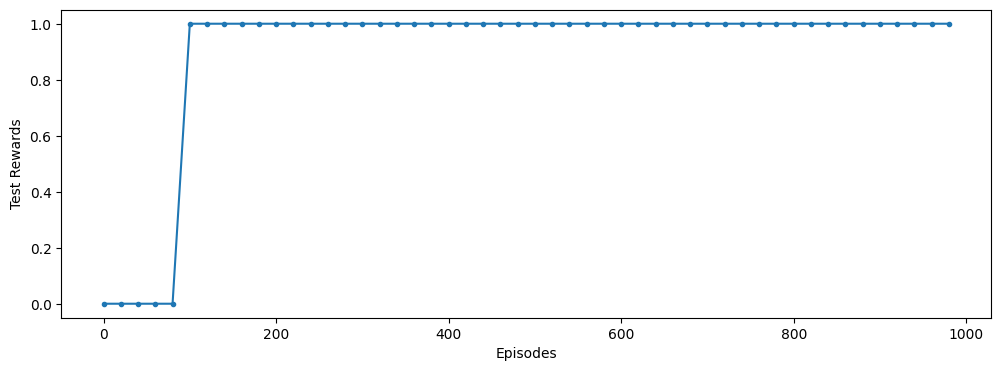

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))
plt.errorbar(test_episodes, test_avg_rewards, test_std_rewards, marker = '.')
plt.xlabel('Episodes')
plt.ylabel('Test Rewards')
plt.show()

Para evaluar el comportamiento del agente de forma visual, podemos inicializar el ambiente con el argumento `render_mode="human"`. Esta opción no funciona bien en Google Colab, por lo que les recomiendo correr este código desde sus equipos personales.

Veamos primero como se ve un agente que toma **acciones aleatorias**:

In [17]:
env = gym.make("FrozenLake-v1", render_mode="human", map_name="4x4", is_slippery=False)

for episode in range(10):
    done = truncated = False
    state, info = env.reset()
    for timestep in range(100):
        action = env.action_space.sample()  # agent policy that uses the observation and info
        state, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break

env.close()

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


Luego, veamos como se ve el agente que entrenamos con Q-learning:

In [18]:
env = gym.make("FrozenLake-v1", render_mode="human", map_name="4x4", is_slippery=False)

for episode in range(10):
    done = truncated = False
    state, info = env.reset()
    for timestep in range(100):
        action = agent.select_action(state, greedy = True)
        action = action.item()
        state, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break

env.close()

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


Finalmente, veamos como quedó la tabla con los valores Q:

In [19]:
agent.Qtable # noten como los valores son distintos a los iniciales

array([[0.73509189, 0.77378094, 0.6983373 , 0.73509189],
       [0.73509189, 0.        , 0.66292137, 0.69831519],
       [0.6982489 , 0.54968721, 0.46990025, 0.60172276],
       [0.60614198, 0.        , 0.26277443, 0.05283569],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.86776324, 0.        , 0.3218492 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378092],
       [0.81449495, 0.9025    , 0.90241327, 0.        ],
       [0.85111412, 0.94999025, 0.        , 0.75674134],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.90248713, 0.95      , 0.85736916],
       [0.90144915, 0.94983654, 1.        , 0.90178732],
       [0.        , 0.        , 0.        , 0.        ]])

## Stable-Baselines3

En la sección anterior implementamos de forma nativa el algoritmo Q-learning para resolver FrozenLake. Si bien tuvimos resultados satisfactorios, implementar nativamente un algoritmo no es lo más deseable para trabajar de forma profesional, especialmente en el campo de RL donde los algoritmos actuales son **diametralmente de mayor complejidad**.

[`Stable-Baselines3`](https://stable-baselines3.readthedocs.io/en/master/) es una librería que nos facilita la implementación de algoritmos de RL en pocas líneas de código. Gracias a su amplia aceptación y a su equipo de mantenimiento, esta librería se ha posicionado como una de las principales alternativas para resolver problemas de RL, pudiendo hacer uso de sus modelos en pocas líneas de código. 

A diferencia de librerías como scikit-learn, SB3 provee la mayor parte de su soporte a la implementación de modelos *deep*, es decir, modelos que usan **redes neuronales** por detrás. De esta forma, no sólo podemos implementar modelos de RL en pocas líneas de código, sino que estos modelos además son bastantes cercanos al **estado del arte**.

<div style="text-align: center;">
    <img src="https://stable-baselines3.readthedocs.io/en/master/_static/logo.png" style="width: 30%;">
</div>

Veamos como hacer uso de `SB3` para resolver el problema FrozenLake usando DQN (Q-learning pero con redes neuronales):

In [20]:
import gymnasium as gym
from stable_baselines3 import DQN

# Create environment
env = gym.make("FrozenLake-v1", render_mode="rgb_array", map_name="4x4", is_slippery=False)

# init agent
model = DQN("MlpPolicy", env, verbose=0)
# train the agent and display a progress bar
model.learn(total_timesteps=int(2e5), progress_bar=True)

/home/stud/giturra/.local/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Noten como para entrenar el agente no tuvimos que escribir el loop de entrenamiento. 

**Ojo! Como estos modelos son de mayor complejidad, en algunos casos el entrenamiento puede tardar bastante. Pueden acelerar exponencialmente el entrenamiento de su modelo ejecutando el código en Google Colab y habilitando la opción de GPU.**

Luego, pueden exportar el modelo entrenado a un archivo `.zip` en pocas lineas de código:

In [21]:
model.save("dqn_frozen") # export model (i.e from Google Colab)
del model  # delete trained model to demonstrate loading
model = DQN.load("dqn_frozen", env=env) # load model

Pasemos ahora a evaluar nuestro agente usando la función `evaluate_policy`. Al igual que en la sección anterior, esta función nos devuelve la recompensa promedio y su desviación obtenida por el agente:

In [22]:
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the agent
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
mean_reward, std_reward

(1.0, 0.0)

Finalmente, podemos evaluar de manera visual el comportamiento de nuestro agente usando el mismo esquema de código:

In [23]:
env = gym.make("FrozenLake-v1", render_mode="human", map_name="4x4", is_slippery=False)

for episode in range(10):
    done = truncated = False
    state, info = env.reset()
    for timestep in range(100):
        action, _states = model.predict(state, deterministic=True)
        action = action.item() # important step: gather action of array
        state, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
env.close()

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


## Bonus: Ambientes Custom

Si ya tienen un conocimiento básico de RL, el siguiente paso natural es **usar RL para resolver nuestros propios problemas**. 

Para eso, deben seguir los siguientes pasos:

1. Formular problema como un MDP (es decir, definir estados, acciones y recompensas)
2. Desarrollar el Ambiente de entrenamiento
3. Entrenar y desplegar el modelo

Para hacerlo compatible con el notebook que vimos en esta clase, el ambiente debe seguir la siguiente estructura:

```python
import gymnasium as gym

class CustomEnv(gym.Env):
    def __init__(self):
        self.observation_space = ... # dimensión de la observación
        self.action_space = ... # dimensión de las acciones

    def reset(self):
        return observation # devolver observación inicial

    def step(self, action):

        # acá debe estar programada la dinámica del ambiente
        # es decir, S_t --> A_t --> S_t+1

        return observation, reward, done, info # devolver nueva observacion y recompensa
```

Finalmente, entrenan el agente para resolver su problema:

```python
env = CustomEnv(...)
model = DQN("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=int(2e5), progress_bar=True)
```

Link de referencia:

- [Stable Baselines](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html)

## Bibliografía

- Sutton, R. S., & Barto, A. G. (2018). *Reinforcement learning: An introduction*. MIT press.
- [RL Course by David Silver](https://www.youtube.com/watch?v=2pWv7GOvuf0&list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-)
- [Deep RL Course - HuggingFace](https://huggingface.co/learn/deep-rl-course/unit2/introduction)